# Load data
<https://www.kaggle.com/c/bike-sharing-demand>

In [1]:
import numpy as np
import pandas as pd
from data.utils import split_data

In [2]:
# Load data
df = pd.read_table('data/bike.csv', sep=',',
                   header=0, index_col=None)
columns = list(df.columns)

# Split datetime column
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

# Remove datetime column
df = df.drop('datetime', axis=1)

# Reorder columns
df = df[['year', 'month', 'day', 'hour'] + columns[1:]]

# Feature names
feature_names = list(map(str.title, df.columns[:-3]))

In [3]:
# Split data, with total count serving as regression target
train, val, test = split_data(df.values, seed=123,
                              val_portion=0.1,
                              test_portion=0.1)
Y_train = train[:, -1].copy()
Y_val = val[:, -1].copy()
Y_test = test[:, -1].copy()
train = train[:, :-3].copy()
val = val[:, :-3].copy()
test = test[:, :-3].copy()

# Train model

In [4]:
import xgboost as xgb

In [5]:
# Set up data
dtrain = xgb.DMatrix(train, label=Y_train)
dval = xgb.DMatrix(val, label=Y_val)

# Parameters
param = {
    'max_depth' : 10,
    'objective': 'reg:squarederror',
    'nthread': 4
}
evallist = [(dtrain, 'train'), (dval, 'val')]
num_round = 50

# Train
model = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)

In [6]:
# Calculate performance
mean = np.mean(Y_train)
base_mse = np.mean((mean - Y_test) ** 2)
mse = np.mean((model.predict(xgb.DMatrix(test)) - Y_test) ** 2)

print('Base rate MSE = {:.2f}'.format(base_mse))
print('Model MSE = {:.2f}'.format(mse))

Base rate MSE = 31590.49
Model MSE = 1979.87


# Calculate feature importance

In [7]:
import sage
import matplotlib.pyplot as plt

In [8]:
# Setup and calculate
imputer = sage.MarginalImputer(test, samples=512)
sampler = sage.PermutationSampler(model, imputer, 'mse')
sage_values = sampler(test, Y_test)

Estimating convergence time
batch size = batch * samples = 262144


StdDev Ratio = 0.1056 (Converge at 0.0500)
StdDev Ratio = 0.0717 (Converge at 0.0500)
StdDev Ratio = 0.0575 (Converge at 0.0500)
StdDev Ratio = 0.0502 (Converge at 0.0500)
StdDev Ratio = 0.0448 (Converge at 0.0500)
Detected convergence



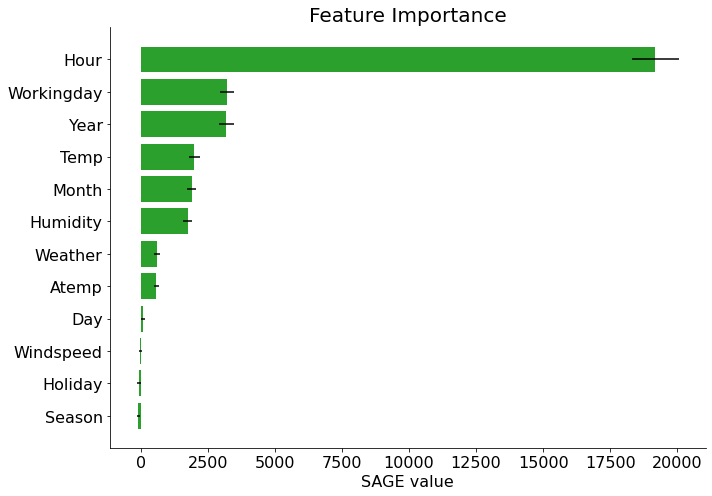

In [9]:
# Plot results
sage_values.plot(feature_names)